Name: Ali Gowani <br>
Contact: https://www.linkedin.com/in/aliagowani/<br><br>

Title: Part 1: Regression Experiment for Intelligent Contact Center Employee performance<br>
Pycaret Version: 2.1<br><br>
Created: Monday, August 24, 2020 <br>
Updated: Monday, August 31, 2020 <br>
<br>

# 0. Overview: Actual Employee Performance Case in Machine Learning (Regression) using Pycaret 2.1

We are going to utilize a low-code Machine Learning Python library, Pycaret (version 2.1), to predict the First Call Resolution (FCR) metric for Customer Service Agents (Employees) in Call Centers. FCR is an important metric in a call center as it indicates the percentage of issues that were resolved when the customer called the first time. We want to ensure that customers do not keep calling back to resolve an issue as it costs the company money when the issue is not resolved the first time.

Below is the approach we will take to predict a Customer Service Agent or Contact Agents FCR metric:
<ol>
<li>Conduct Exploratory Data Analysis (EDA) on the real data from a global call center.</li>
<li>Execute regerssion models to determine how accurately we can predict the FCR metric for each employee.</li>
<li>Create a classification indicator to determine whether predicting an employee's increase or decrease in FCR metric performance is more meaningful than regression.</li>
</ol>

We will leverage a real-case data from a business process outsourcer (BPO) that supports many Fortune 500 companies. *Note: dataset has been sanitized of personal information as it is a real dataset.

Let's get started!

# 1. Load Libraries

In [1]:
# Import libraries for data processing.
import numpy as np
import pandas as pd
import warnings
import time
warnings.filterwarnings('ignore')

# Import libraries for visualization and set default values.
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])

from sklearn import set_config
set_config(display='diagram')

In [2]:
# Install and import Pycaret library for transformation and classification.
# !pip install pycaret
from pycaret.regression import *

# Confirm Pycaret version is 2.1
from pycaret.utils import version
print('Confirm Pycaret version is 2.1.2?')
print('Pycaret Version: ', version())

Confirm Pycaret version is 2.1.2?
Pycaret Version:  2.1.2


# 2. Load Dataset

In [3]:
# Load Dataset.
url = 'https://raw.githubusercontent.com/aliagowani/Pycaret_2.1_Regression_EmployeePerformance/master/employee_performance.csv?token=AMLWIYQHZO4XANFWX3IP5B27LGQIY'
dataset = pd.read_csv(url)

In [4]:
# Check shape of dataset and view first few observations to ensure data loaded correctly.
print("Shape of dataset (observations, features):", dataset.shape)
dataset.head(5).round(2)

Shape of dataset (observations, features): (102, 19)


,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Site,Function_Field,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
0,384091,100.00,90.00,90.00,96.15,100.00,96.88,100.00,Kuala Lumpur,Agent,33,163,95.06,94.23,4.87,0,0,85.71,97.14
1,369185,94.00,100.00,96.87,96.87,96.10,95.89,98.33,Kuala Lumpur,Agent,33,306,95.08,94.67,4.83,0,0,100.00,88.64
2,360854,94.44,80.00,92.94,92.94,100.00,93.94,96.30,Kuala Lumpur,Agent,32,138,94.16,94.74,4.82,2,1,80.00,92.31
3,374407,100.00,95.00,96.63,96.63,92.50,95.65,100.00,Kuala Lumpur,Agent,32,148,98.65,95.83,4.84,0,0,94.44,100.00
4,372496,96.88,95.83,94.28,94.28,83.33,95.35,100.00,Kuala Lumpur,Agent,29,142,97.18,98.55,4.86,0,0,100.00,90.91


# 3. Exploratory Data Analysis (EDA)

In [5]:
# Below is a high-level description of each feature. The data set is comprised of 102 agents and we have 19 features to evaluate. The data is between the time period of June 1, 2020 and July 31, 2020, with the 'Actual Value' as the Actual FCR value of each agent for August 7, 2020. The goal is to create a model that predicts the FCR for an employee can have at the end of the week (Friday). 

# 'Agent_ID': unique identifier of the employee or agent.
# 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday': shows the FCR percent for each agent as an aggregate (mean). The higher the percentage the higher the rate at which the customer's issue was resolved in the first call. 
# 'Site': city location of the call center.
# 'Function_Field': this is the role of the employee. In our case, it should all be Agents. 
# 'tenure': tenure of the agent at the company in months. 
# 'Total number of calls': number of all phone calls taken by the agent in the given timeframe.
# 'Assistance': percentage of time the agent needed to provide additional assistance by escalating to supervisor. 
# 'Recommend': percentage of time the agent would be recommended by the customer to resolve an issue. 
# 'CSat': average survey response (on a scale from 1 (least satisfied) to 5 (most satisfied)) that the customer was satisfied with the experience. 
# 'total coaching': number of times the agent received coaching sessions from supervisor to improve FCR metric in the given timeframe. 
# 'total coaching improved': number of times the agent's FCR value increased after a week from the initial coaching. 
# 'Actual Value': the label we are trying to predict. It is the next Friday (August 7, 2020) FCR value for the agent. 
# 'FCR Week before': a strong indicator is how well the agent performed the previous Friday. This is the FCR value for the Friday before the predicted value ('Actual Value'). 

# Describe the features in the dataset, such as, count, mean, standard deviation, min, max, etc.
dataset.describe().round(2)

,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before
count,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00,102.00
mean,371097.88,95.65,94.10,95.55,95.19,94.91,94.97,96.54,14.24,173.94,95.83,95.62,4.81,1.61,0.88,96.04,95.58
std,10742.44,4.36,10.47,3.56,3.94,5.45,4.68,3.83,6.85,77.23,1.78,2.00,0.09,1.78,1.07,5.70,4.67
min,353039.00,77.78,0.00,80.56,80.00,75.00,80.00,83.33,3.00,52.00,89.66,87.16,4.41,0.00,0.00,75.00,80.00
25%,362108.00,93.75,92.45,93.87,93.28,92.31,92.94,95.00,8.00,116.25,94.71,94.67,4.77,0.00,0.00,94.12,92.92
50%,371781.00,96.15,94.94,95.83,96.01,96.00,95.86,97.33,15.00,158.00,95.81,95.59,4.82,1.00,1.00,100.00,96.49
75%,380697.75,100.00,100.00,97.56,97.57,100.00,98.15,100.00,17.00,226.25,96.99,97.11,4.87,2.00,1.00,100.00,100.00
max,388627.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,33.00,388.00,100.00,100.00,4.98,9.00,4.00,100.00,100.00


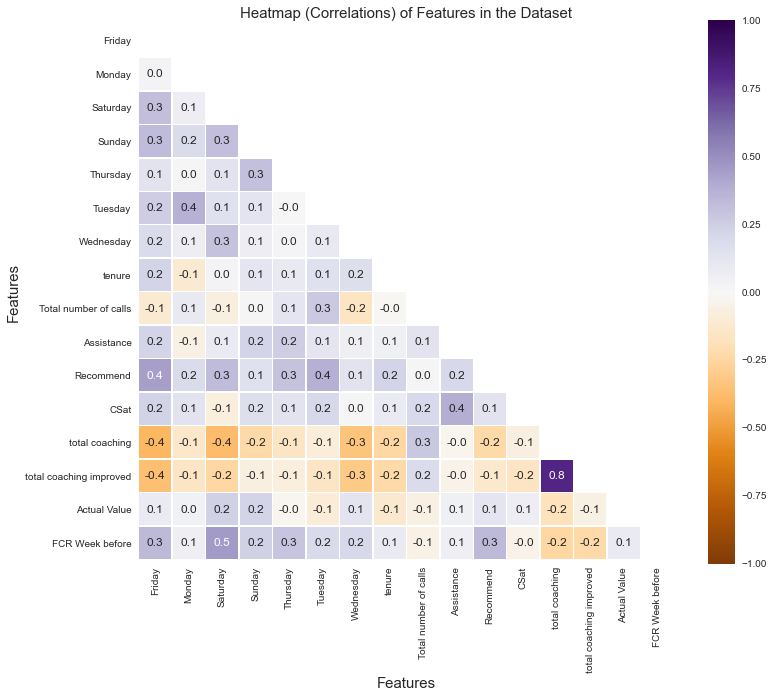

In [6]:
# Create a correlation for the dataset.
dataset_corr = dataset.corr().round(4)

# Drop Agent_ID from correlation dataset.
dataset_corr = dataset_corr.drop(["Agent_ID"], axis=1)
dataset_corr = dataset_corr.drop(["Agent_ID"], axis=0)

# Create a correlation matrix. Only bottom left corner valued. 
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

# Generate the corrleation matrix (heatmap) using Seaborn. 
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center = 0, vmin=-1, square=True, cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 12}, fmt='.1f')
    plt.title('Heatmap (Correlations) of Features in the Dataset', fontsize=15)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Features', fontsize=15)
plt.show()

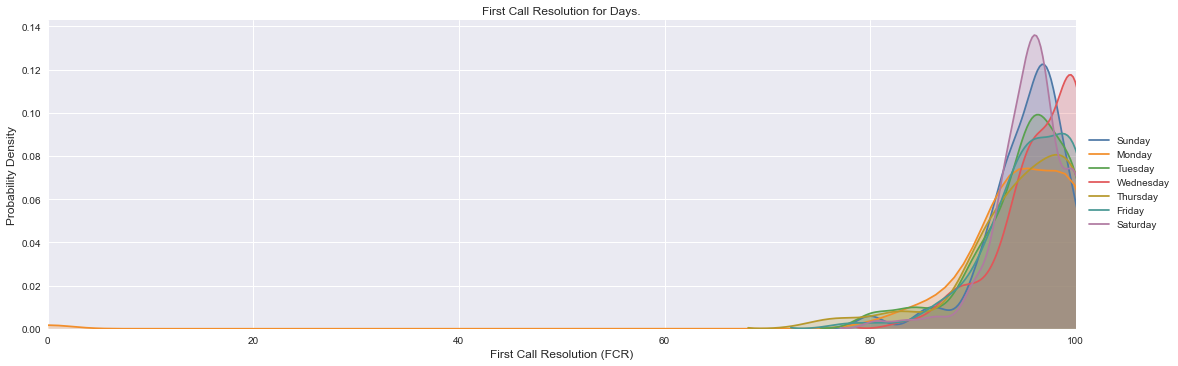

In [7]:
# Visualize the FCR for specific day in the probability density chart. 
facet = sns.FacetGrid(dataset, aspect = 3, height=5)
facet.map(sns.kdeplot, 'Sunday', shade = True, color='#4E79A7')
facet.map(sns.kdeplot, 'Monday', shade = True, color='#F28E2B')
facet.map(sns.kdeplot, 'Tuesday', shade = True, color='#59A14F')
facet.map(sns.kdeplot, 'Wednesday', shade = True, color='#E15759')
facet.map(sns.kdeplot, 'Thursday', shade = True, color='#B6992D')
facet.map(sns.kdeplot, 'Friday', shade = True, color='#499894')
facet.map(sns.kdeplot, 'Saturday', shade = True, color='#B07AA1')
facet.set(xlim = (0, dataset['Thursday'].max()))
facet.add_legend()
plt.title('First Call Resolution for Days.', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlabel('First Call Resolution (FCR)', fontsize=12)
plt.show()

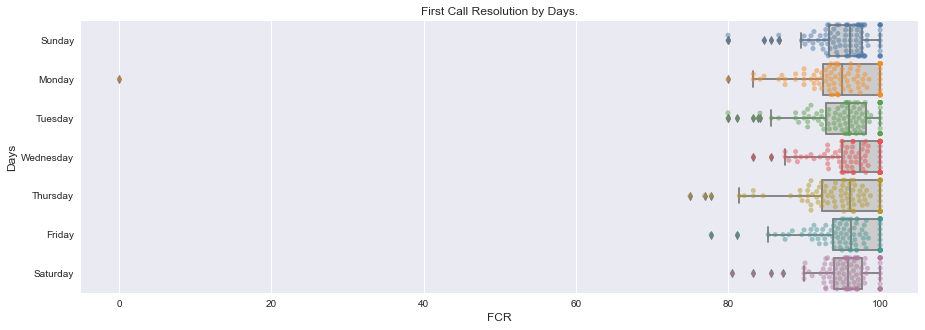

In [8]:
# Visualize the dispersion of FCR values in a given day and identify the outliers. 

# Create a color set that matches the probability density chart. 
my_pal = {'Sunday': '#4E79A7','Monday': '#F28E2B', 'Tuesday': '#59A14F', 'Wednesday': '#E15759', 'Thursday': '#B6992D', 'Friday': '#499894', 'Saturday': '#B07AA1'}

# Generate a boxplot using Seaborn. 
dataset_boxplot = pd.DataFrame(data = dataset, columns = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.figure(figsize=(15,5))
sns.boxplot(x="value", y="variable", data=pd.melt(dataset_boxplot), color='#cccccc')
sns.swarmplot(x="value", y="variable", data=pd.melt(dataset_boxplot), palette=my_pal, alpha=0.5)
plt.title('First Call Resolution by Days.', fontsize=12)
plt.ylabel('Days', fontsize=12)
plt.xlabel('FCR', fontsize=12)
plt.show()

# 4. Conduct Regression Model in Pycaret

In [22]:
# Transform dataset (transform, bin and create dummy variables) and split the dataset. In addition, we are logging experiments and plots for those experiment to be viewed later with MLflow. 
reg_fcr = setup(data=dataset, target='Actual Value', session_id=786, transformation=True, normalize=False, train_size=0.75, numeric_features=('Sunday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday', 'Friday', 'Total number of calls', 'CSat', 'total coaching', 'total coaching improved', 'FCR Week before'), remove_outliers=True, outliers_threshold=0.05, remove_multicollinearity=True, multicollinearity_threshold=0.9, feature_selection=True, feature_interaction=True, silent=False, ignore_features=['Agent_ID'], combine_rare_levels=True, polynomial_features=True, trigonometry_features=True, feature_selection_threshold=0.4, feature_selection_method='classic', folds_shuffle=True, log_experiment=True, experiment_name='reg_fcr_experiments', log_plots=True)


Setup Succesfully Completed.


,Description,Value
0,session_id,786
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(102, 19)"
4,Missing Values,False
5,Numeric Features,16
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [23]:
# Below is a list of models that Pycaret can use for regression. The ID for each regression can be used to include or exclude models for various functions.
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model.Lasso,True
ridge,Ridge Regression,sklearn.linear_model.Ridge,True
en,Elastic Net,sklearn.linear_model.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model.OMP,True
br,Bayesian Ridge,sklearn.linear_model.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model.ARDRegression,False


In [24]:
# We can do a compare_models() function without assigning it to a variable. However, we have top 5 models selected using n_select and assigning it to top5 variable. We plan to use this for Stacking and Blending purposes. We have excluded 'RANSAC' (Random Sample Consensus) and 'KNN' (K-Nearest Neighbor) models and have adjusted the default fold value from 10 to 5. 
top5 = compare_models(n_select=5, exclude=(['ransac', 'knn']), sort='RMSE', fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Bayesian Ridge,3.8530,24.9309,4.9270,0.2160,0.0536,0.0419,0.0059
1,Elastic Net,4.1033,30.5868,5.4337,0.0717,0.0593,0.0450,0.0035
2,Light Gradient Boosting Machine,4.2716,31.9817,5.5611,-0.0117,0.0606,0.0467,0.0136
3,Lasso Regression,4.3939,35.2840,5.8253,-0.0567,0.0635,0.0483,0.0033
4,CatBoost Regressor,4.5205,36.5047,5.9352,-0.1141,0.0647,0.0497,3.9441
5,Lasso Least Angle Regression,4.5154,36.6081,5.9376,-0.1017,0.0647,0.0497,0.0031
6,Extra Trees Regressor,4.7309,37.7014,6.1252,-0.4044,0.0667,0.0516,0.1333
7,Ridge Regression,4.9391,37.7206,6.1281,-0.3783,0.0646,0.0523,0.0065
8,AdaBoost Regressor,4.5069,39.7578,6.2164,-0.2615,0.0677,0.0495,0.1078
9,Random Forest,4.8928,41.1348,6.3693,-0.4653,0.0691,0.0531,0.1906


In [25]:
# Sometimes you want to include the output of the compare_models() as a screenshot into a report. However, with the yellow highlights it gets difficult to read. Pycaret has thought of that and you can use the pull() function to show the model results in the sort by or ascending order.
pull().sort_values(by='RMSE', ascending=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Bayesian Ridge,3.8530,24.9309,4.9270,0.2160,0.0536,0.0419,0.0059
1,Elastic Net,4.1033,30.5868,5.4337,0.0717,0.0593,0.0450,0.0035
2,Light Gradient Boosting Machine,4.2716,31.9817,5.5611,-0.0117,0.0606,0.0467,0.0136
3,Lasso Regression,4.3939,35.2840,5.8253,-0.0567,0.0635,0.0483,0.0033
4,CatBoost Regressor,4.5205,36.5047,5.9352,-0.1141,0.0647,0.0497,3.9441
5,Lasso Least Angle Regression,4.5154,36.6081,5.9376,-0.1017,0.0647,0.0497,0.0031
6,Extra Trees Regressor,4.7309,37.7014,6.1252,-0.4044,0.0667,0.0516,0.1333
7,Ridge Regression,4.9391,37.7206,6.1281,-0.3783,0.0646,0.0523,0.0065
8,AdaBoost Regressor,4.5069,39.7578,6.2164,-0.2615,0.0677,0.0495,0.1078
9,Random Forest,4.8928,41.1348,6.3693,-0.4653,0.0691,0.0531,0.1906


In [26]:
# We can tune our top 5 models dynamically with a higher iteration rate (n_iter) to find more optimal hyper parameters over a larger search space. 
tuned_top5 = [tune_model(i, n_iter=120, optimize='RMSE', fold=5) for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.9727,33.8766,5.8204,0.1660,0.0650,0.0451
1,3.5366,16.4115,4.0511,-0.3695,0.0417,0.0363
2,5.3931,52.4415,7.2416,-0.1831,0.0792,0.0600
3,5.2363,53.6051,7.3215,-0.0671,0.0820,0.0600
4,3.8792,25.0667,5.0067,0.0239,0.0535,0.0416
Mean,4.4036,36.2803,5.8883,-0.0860,0.0643,0.0486
SD,0.7596,14.7487,1.2683,0.1821,0.0153,0.0097


<Figure size 576x396 with 0 Axes>

In [27]:
# Blending models is an ensemble method of combining different machine learning algorithms and use a majority vote to build consensus of final prediction values. Let's try building a blending model from our top 5 models and evaluate the results. 
blender_specific = blend_models(estimator_list=tuned_top5[0:], fold=5, optimize='RMSE', choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.1957,28.8834,5.3743,0.2889,0.0596,0.0468
1,3.1893,13.4270,3.6643,-0.1204,0.0375,0.0326
2,4.3371,31.8462,5.6432,0.2815,0.0621,0.0478
3,4.5021,40.4584,6.3607,0.1946,0.0715,0.0512
4,3.2654,18.9642,4.3548,0.2615,0.0467,0.0351
Mean,3.8979,26.7158,5.0795,0.1812,0.0555,0.0427
SD,0.5566,9.5557,0.9565,0.1545,0.0120,0.0074


<Figure size 576x396 with 0 Axes>

In [28]:
# Below is a diagram view of the model. 
blender_specific

VotingRegressor(estimators=[('Bayesian Ridge_0',
                             BayesianRidge(alpha_1=0.0001, alpha_2=0.0001,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=0.001, lambda_2=0.3,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False)),
                            ('Elastic Net_1',
                             ElasticNet(alpha=0.34, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.1,
                                        max_iter=100...
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsample_freq=0)),
                            ('Lasso_3',
                             Lasso(alpha=0.42, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=786, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('CatBoost Regressor_4',
                             <catboost.core.CatBoostRegressor object at 0x7fe285330f40>)],
                n_jobs=-1, verbose=False, weights=None)

In [29]:
# Stacking models is an ensemble method of using meta learning, where a meta model is created using multiple base estimators to generate the final prediction. Let's try building a stacking model from our top 5 models and evaluate the results. 
stacker_specific = stack_models(estimator_list=tuned_top5[1:], meta_model=tuned_top5[0], fold=5, optimize='RMSE', choose_better=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.7371,25.3112,5.0310,0.3769,0.0556,0.0416
1,2.9857,12.1294,3.4827,-0.0122,0.0356,0.0304
2,5.0167,42.6422,6.5301,0.0380,0.0715,0.0552
3,4.5040,35.4544,5.9544,0.2942,0.0667,0.0507
4,3.2632,17.2954,4.1588,0.3265,0.0444,0.0348
Mean,3.9013,26.5665,5.0314,0.2047,0.0548,0.0426
SD,0.7589,11.2551,1.1187,0.1596,0.0134,0.0093


<Figure size 576x396 with 0 Axes>

In [30]:
# Below is a diagram view of the model. 
stacker_specific

StackingRegressor(cv=5,
                  estimators=[('ElasticNet_0',
                               ElasticNet(alpha=0.34, copy_X=True,
                                          fit_intercept=True, l1_ratio=0.1,
                                          max_iter=1000, normalize=False,
                                          positive=False, precompute=False,
                                          random_state=786, selection='cyclic',
                                          tol=0.0001, warm_start=False)),
                              ('LGBMRegressor_1',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_t...
                                     warm_start=False)),
                              ('CatBoostRegressor_3',
                               <catboost.core.CatBoostRegressor object at 0x7fe285330f40>)],
                  final_estimator=BayesianRidge(alpha_1=0.0001, alpha_2=0.0001,
                                                alpha_init=None,
                                                compute_score=False,
                                                copy_X=True, fit_intercept=True,
                                                lambda_1=0.001, lambda_2=0.3,
                                                lambda_init=None, n_iter=300,
                                                normalize=False, tol=0.001,
                                                verbose=False),
                  n_jobs=-1, passthrough=True, verbose=0)

# 5. Evaluate Results and Finalize Model

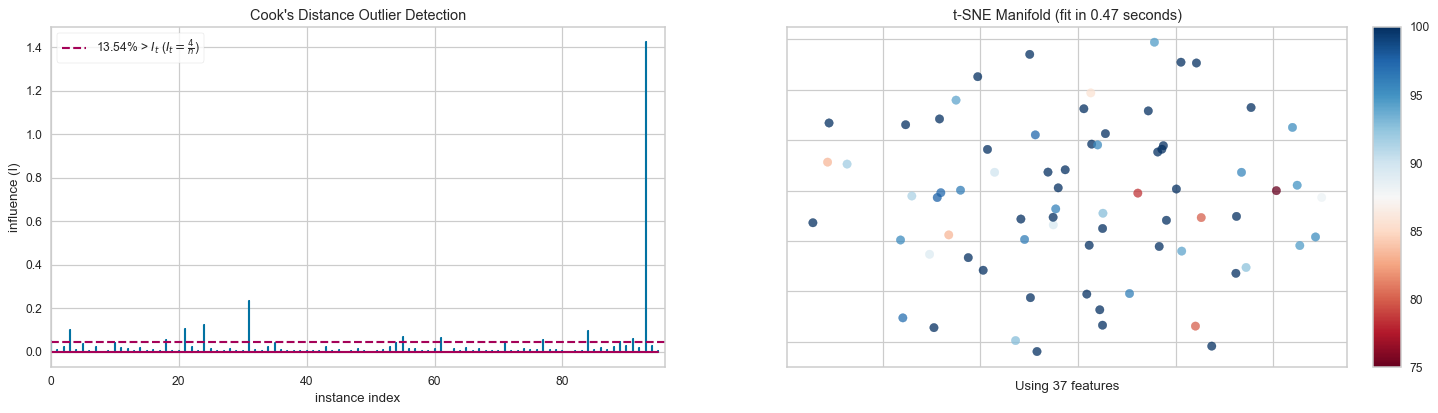

In [31]:
# We can use Pycaret's built in plot_model() function to generate side-by-side plots: the Cook's Distance Outliers and t-SNE Manifold charts. 
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,2,1)
plot_model(blender_specific, plot='cooks', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(5,2,2)
plot_model(blender_specific, plot='manifold', save=True, verbose=False, scale=1.1)
plt.savefig('plots_cooks_and_manifold.png', dpi=300, pad_inches=0.25)
plt.show()

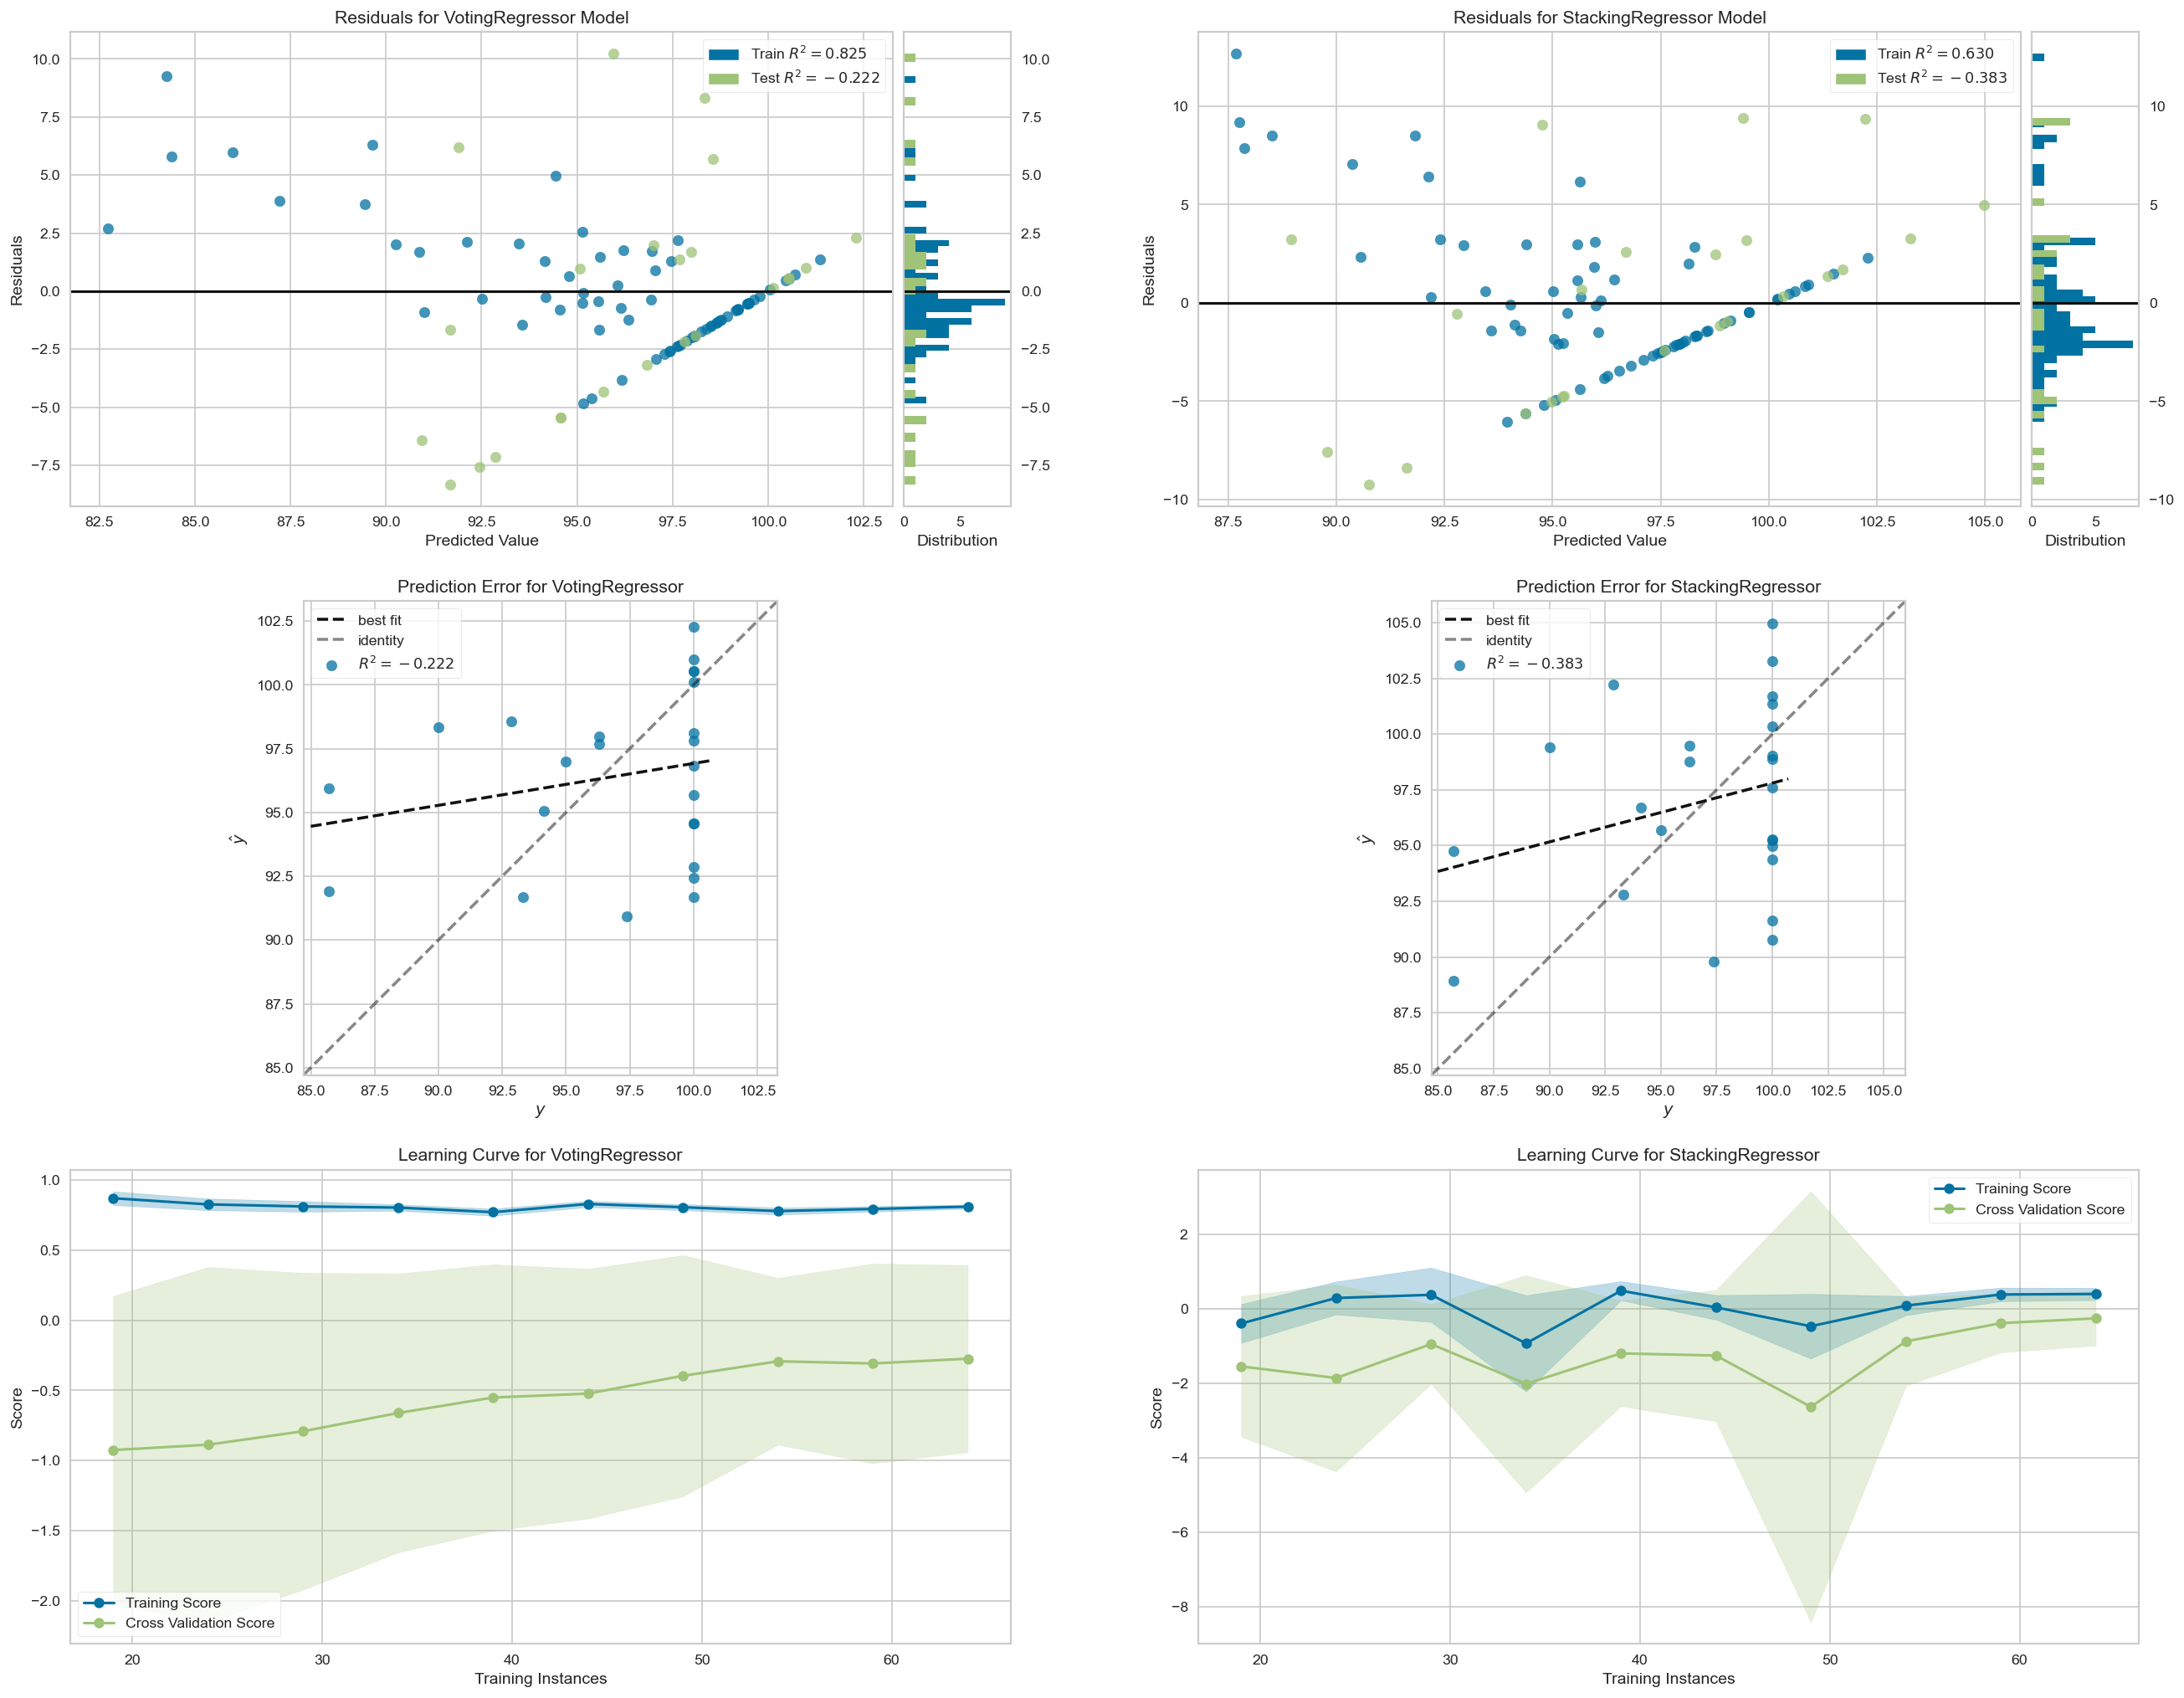

In [32]:
# We can use Pycaret's built in plot_model() function to generate side-by-side plots: the Residuals chart, Prediction Error and Cross Validation (learning) charts. Let's compare the Blend and Stack model plots in a side-by-side comparison. 
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(3,2,1)
plot_model(blender_specific, plot='residuals', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,2)
plot_model(stacker_specific, plot='residuals', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,3)
plot_model(blender_specific, plot='error', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,4)
plot_model(stacker_specific, plot='error', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,5)
plot_model(blender_specific, plot='learning', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(3,2,6)
plot_model(stacker_specific, plot='learning', save=True, verbose=False, scale=1.1)
plt.savefig('plots_blender_vs_stacker.png', dpi=300, pad_inches=0.25)
plt.show()

In [33]:
# We can execute the predict_model() function to use the model to generate the predicted values. 
pred_tunded_blender = predict_model(blender_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,3.9375,24.1186,4.9111,-0.2215,0.0515,0.0413


In [34]:
# We can execute the predict_model() function to use the model to generate the predicted values. 
pred_tunded_stacker = predict_model(stacker_specific)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,4.2489,27.3059,5.2255,-0.3829,0.0542,0.0444


In [35]:
# The Blend model seems to perform better in both our train and test so let us finalize it. The finalize_model() function trains the model on the entire dataset. 
finalize_blender = finalize_model(blender_specific)
finalize_blender

VotingRegressor(estimators=[('Bayesian Ridge_0',
                             BayesianRidge(alpha_1=0.0001, alpha_2=0.0001,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=0.001, lambda_2=0.3,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False)),
                            ('Elastic Net_1',
                             ElasticNet(alpha=0.34, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.1,
                                        max_iter=100...
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsample_freq=0)),
                            ('Lasso_3',
                             Lasso(alpha=0.42, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=786, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('CatBoost Regressor_4',
                             <catboost.core.CatBoostRegressor object at 0x7fe285a2e4c0>)],
                n_jobs=-1, verbose=False, weights=None)

<Figure size 576x396 with 0 Axes>

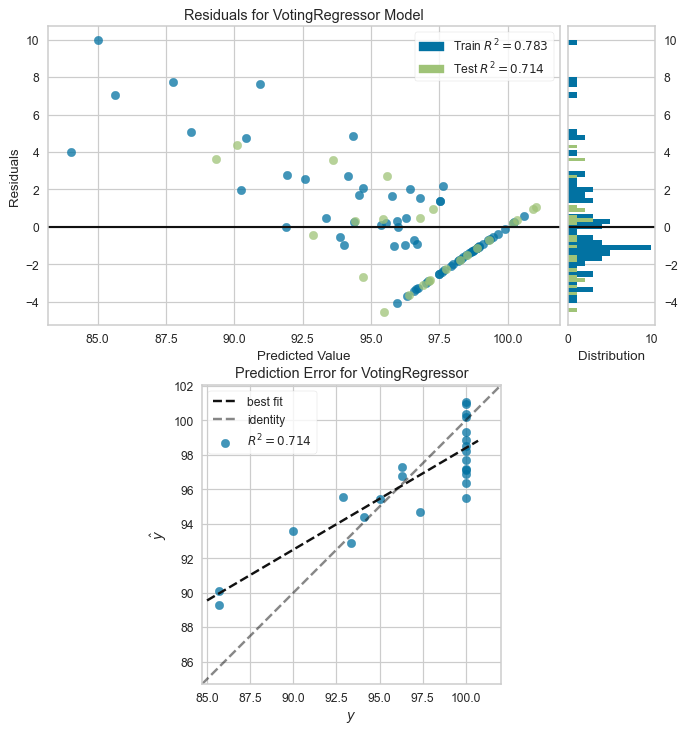

In [36]:
# We can use the Pycaret's built-in plot_model() function to generate Residuals and Error plots for the finalized blend model. 
fig = plt.figure(figsize=(9,10))
ax = fig.add_subplot(2,1,1)
plot_model(finalize_blender, plot='residuals', save=True, verbose=False, scale=1.1)
ax = fig.add_subplot(2,1,2)
plot_model(finalize_blender, plot='error', save=True, verbose=False, scale=1.1)
plt.savefig('plots_pred_final_blender.png', dpi=300, pad_inches=0.25)
plt.show()

In [37]:
# The predict_model() can be executed with the final blend model over the entire dataset and saved to a csv file. 
pred_final_blender = predict_model(finalize_blender, data=dataset)
pred_final_blender.to_csv('pred_final_blender.csv')
pred_final_blender.describe()

,Agent_ID,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,tenure,Total number of calls,Assistance,Recommend,CSat,total coaching,total coaching improved,Actual Value,FCR Week before,Label
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,371097.882353,95.650593,94.096218,95.552565,95.186928,94.907817,94.968364,96.544911,14.235294,173.941176,95.832315,95.622119,4.807622,1.607843,0.882353,96.036176,95.578725,96.412347
std,10742.442598,4.355132,10.465289,3.558242,3.941495,5.453729,4.675461,3.829237,6.846516,77.234608,1.784522,1.997818,0.089011,1.775281,1.074402,5.700526,4.674600,3.531668
min,353039.000000,77.777778,0.000000,80.555556,80.000000,75.000000,80.000000,83.333333,3.000000,52.000000,89.655172,87.162162,4.413793,0.000000,0.000000,75.000000,80.000000,84.021200
25%,362108.000000,93.750000,92.445055,93.873767,93.284134,92.307692,92.938312,95.000000,8.000000,116.250000,94.711729,94.666667,4.767000,0.000000,0.000000,94.120000,92.920000,95.368275
50%,371781.000000,96.153846,94.935897,95.833414,96.013439,96.000000,95.861872,97.329060,15.000000,158.000000,95.806136,95.589688,4.819492,1.000000,1.000000,100.000000,96.490000,97.132350
75%,380697.750000,100.000000,100.000000,97.556895,97.568007,100.000000,98.146168,100.000000,17.000000,226.250000,96.988326,97.113066,4.865194,2.000000,1.000000,100.000000,100.000000,98.762300
max,388627.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,33.000000,388.000000,100.000000,100.000000,4.984127,9.000000,4.000000,100.000000,100.000000,104.431900


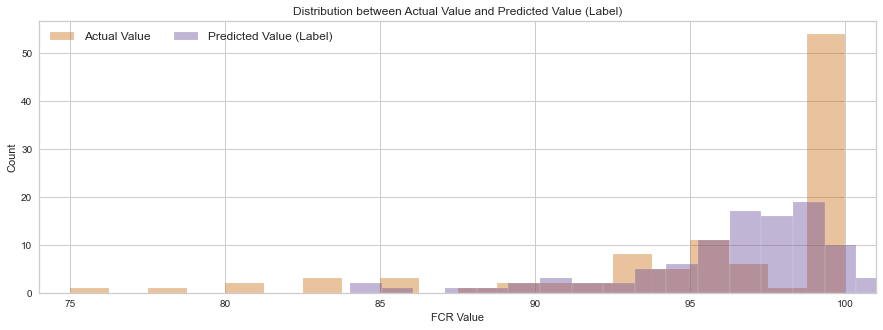

In [38]:
# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(pred_final_blender["Actual Value"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(pred_final_blender["Label"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("FCR Value")
plt.xlim((74,101))
plt.legend(('Actual Value', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

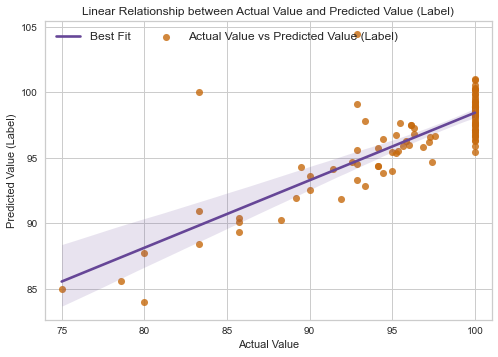

In [39]:
# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="Actual Value", y="Label", data=pred_final_blender, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Actual Value")
plt.xlim((74,101))
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

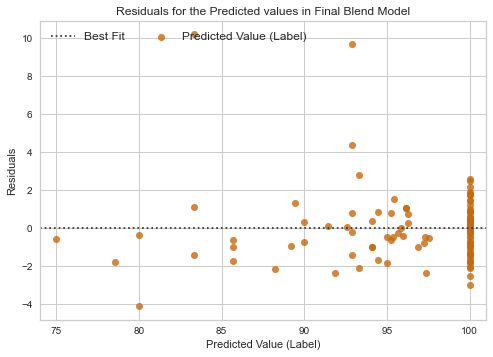

In [40]:
# We can compare the Predicted Values (Label) and Residuals in an error plot over the entire dataset. 
sns.residplot(x="Actual Value", y="Label", data=pred_final_blender, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Residuals for the Predicted values in Final Blend Model")
plt.ylabel("Residuals")
plt.xlabel("Predicted Value (Label)")
plt.xlim((74,101))
plt.legend(('Best Fit', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

In [45]:
# We had enabled log_experiement and log_plots in the setup() function. Pycaret does a wonderful job in leveraging MLflow so all experiments can be logged and analyzed. This can be accomplished with a simple one-line command and viewed in your browser. 

!mlflow ui

[2020-09-03 09:34:34 -0500] [4899] [INFO] Starting gunicorn 20.0.4
[2020-09-03 09:34:34 -0500] [4899] [INFO] Listening at: http://127.0.0.1:5000 (4899)
[2020-09-03 09:34:34 -0500] [4899] [INFO] Using worker: sync
[2020-09-03 09:34:34 -0500] [4901] [INFO] Booting worker with pid: 4901
^C
[2020-09-03 09:38:24 -0500] [4899] [INFO] Handling signal: int
[2020-09-03 09:38:24 -0500] [4901] [INFO] Worker exiting (pid: 4901)


# 6. Client Presentation and Next Steps

We presented the results of our experiment to the client, thinking they would be impressed. Initially, they shared their excitement of leveraging the models to predict performance. However, having a RMSE of ~4.6 is not going to be viewed in a positve manner with employees and their supervisors. 

However, we decided to approach it differently. Instead of looking at a finite value, we determined that if we can predict whether the employee was going to increase or decrease performance then this would be quite beneficial. In particular, if we can determine that the employee's performance was going to decrease then the supervisor can preempt it and try to mitigate the decrease in employee's performance before it occurs.

In [41]:
# Generating the classification label based on the regression analysis. 
pred_final_blender.loc[(pred_final_blender['Actual Value'] >= pred_final_blender['FCR Week before']) & (pred_final_blender['Label'] > pred_final_blender['FCR Week before']), 'Pred_Class'] = 'True Positive'

pred_final_blender.loc[(pred_final_blender['Actual Value'] < pred_final_blender['FCR Week before']) & (pred_final_blender['Label'] < pred_final_blender['FCR Week before']), 'Pred_Class'] = 'True Negative'

pred_final_blender.loc[(pred_final_blender['Actual Value'] >= pred_final_blender['FCR Week before']) & (pred_final_blender['Label'] < pred_final_blender['FCR Week before']), 'Pred_Class'] = 'False Negative'

pred_final_blender.loc[(pred_final_blender['Actual Value'] < pred_final_blender['FCR Week before']) & (pred_final_blender['Label'] > pred_final_blender['FCR Week before']), 'Pred_Class'] = 'False Positive'

In [42]:
# Saving the classification results to a CSV file and create a data type to store the classification metrics. 
pred_final_blender
pred_final_blender.to_csv('pred_final_blender.csv')

cf_values = pred_final_blender['Pred_Class'].value_counts()
cf_values

True Positive     48
True Negative     30
False Negative    22
False Positive     2
Name: Pred_Class, dtype: int64

[Text(0, 0.5, 'Performance Increase'), Text(0, 1.5, 'Performance Decrease')]

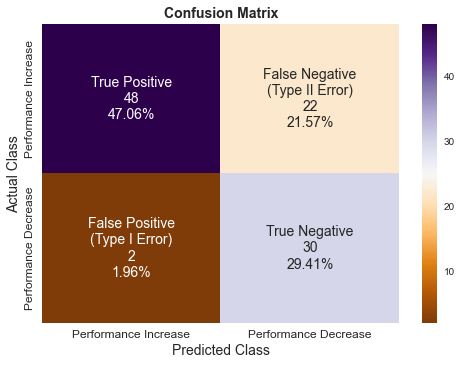

In [43]:
# Create confusion matrix table, along with labels, counts and percentage
cf_matrix = np.array([[cf_values.loc['True Positive'], cf_values.loc['False Negative']],
            [cf_values.loc['False Positive'], cf_values.loc['True Negative']]])

group_names = ['True Positive', 'False Negative\n(Type II Error)', 'False Positive\n(Type I Error)', 'True Negative']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
                
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
                     
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
          
labels = np.asarray(labels).reshape(2,2)

# Create confusion matrix plot using Seaborn
ax = plt.subplot()
plt.rcParams.update({'font.size': 14})
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='PuOr')

# Set labels, title and ticks
ax.set_xlabel('Predicted Class', fontsize=14)
ax.set_ylabel('Actual Class', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.xaxis.set_ticklabels(['Performance Increase', 'Performance Decrease'], fontsize=12)
ax.yaxis.set_ticklabels(['Performance Increase', 'Performance Decrease'], va='center', fontsize=12)

In [46]:
# Below are the classification metrics. 
accuracy = '{0:.2%}'.format((cf_values.loc['True Positive'] + cf_values.loc['True Negative']) / (cf_values.loc['True Positive'] + cf_values.loc['False Positive'] + cf_values.loc['True Negative'] + cf_values.loc['False Negative']))
print('Accuracy: ', accuracy)

sensitivity = '{0:.2%}'.format((cf_values.loc['True Positive']) / (cf_values.loc['True Positive'] + cf_values.loc['False Negative']))
print('Sensitivity (Recall): ', sensitivity)

specificity = '{0:.2%}'.format((cf_values.loc['True Negative']) / (cf_values.loc['True Negative'] + cf_values.loc['False Positive']))
print('Specificity (True Negative Rate): ', specificity)

precision = '{0:.2%}'.format((cf_values.loc['True Positive']) / (cf_values.loc['True Positive'] + cf_values.loc['False Positive']))
print('Precision (Positive Predictive Value): ', precision)

f1 = '{0:.2%}'.format((2 * cf_values.loc['True Positive']) / (2 * cf_values.loc['True Positive'] + cf_values.loc['False Positive'] + cf_values.loc['False Negative']))
print('F1 Score (harmonic mean of Precision and Sensitivity): ', f1)

Accuracy:  76.47%
Sensitivity (Recall):  68.57%
Specificity (True Negative Rate):  93.75%
Precision (Positive Predictive Value):  96.00%
F1 Score (harmonic mean of Precision and Sensitivity):  80.00%


# 6. View Results in MLflow

# 7. Conclusion and Next Steps (Part 2)

sdlfjsldfjsldfjsdlkfsd

# 8. Sources and References

Matplotlib. Retrieved August 24, 2020, from https://matplotlib.org

Pycaret. (2020, May 11). Retrieved August 24, 2020, from https://pycaret.org/

Python. Retrieved August 24, 2020, from https://www.python.org/

Scikit Learn: Learn: Machine learning in Python - scikit-learn 0.16.1 documentation. (n.d.). Retrieved August 24, 2020, from https://scikit-learn.org/

Seaborn. (n.d.). Retrieved August 24, 2020, from https://seaborn.pydata.org/